### Inspect applying readfish to R10 simulated barcodes

In [1]:
import csv
from itertools import zip_longest
from pathlib import Path
from typing import Any, Iterable

import matplotlib.font_manager as font_manager
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import EngFormatter

In [2]:
Path().cwd()

PosixPath('/data/projects/rory_says_hi/icarust_paper_data/notebooks')

In [3]:
plt.style.use("dotfiles-rm/thesis/thesis.mplstyle")
font_dir = "dotfiles-rm/"
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
sns.set_palette("colorblind")
rcParams["font.family"] = "Roboto"

In [4]:
control_seq_sums = ("seq_sums/control/", "Control")
adaptive_1000ms_seq_sums = ("seq_sums/adaptive/", "Adaptive")

In [5]:
seq_sum_dirs = (
    control_seq_sums,
    adaptive_1000ms_seq_sums,

)

In [6]:
BARCODES = {"barcode01", "barcode02", "barcode03"}

In [7]:
def get_seq_sums(directory_path: Path):
    directory_path = (
        directory_path if isinstance(directory_path, Path) else Path(directory_path)
    )
    for seq_sum in sorted(directory_path.rglob("*sequencing_summary*.txt")):
        yield seq_sum

In [8]:
def _yield_records(
    file_path: str, sep: str = "\t", condition: str = None
) -> dict[str, Any]:
    """Yield all records from a given file"""
    with open(file_path) as fh:
        for record in csv.DictReader(fh, delimiter=sep):
            record["Condition"] = condition
            barcode = (
                record["barcode_arrangement"]
                if record["barcode_arrangement"] in BARCODES
                else "Other"
            )
            record["barcode_arrangement"] = barcode
            yield record

In [9]:
def yield_from_seq_sums(file_paths: Iterable[str], condition: str) -> dict[str, Any]:
    for file_path in file_paths:
        yield from _yield_records(file_path, condition=condition)

In [10]:
def make_seq_sum_df(seq_sum_dirs: tuple[tuple[str, str]]) -> dict[str, Any]:
    for seq_sum_dir, condition in seq_sum_dirs:
        yield from yield_from_seq_sums(get_seq_sums(seq_sum_dir), condition)

In [11]:
df = pd.DataFrame(make_seq_sum_df(seq_sum_dirs))

In [12]:
df["sequence_length_template"] = pd.to_numeric(df["sequence_length_template"])

In [13]:
df = df.rename(columns={"barcode_arrangement": "Barcode"})
df = df.sort_values(["Condition", "Barcode"])

In [14]:
def total_yield(group: pd.DataFrame) -> float:
    """
    Returns the total yield for a given group
    """
    return group["sequence_length_template"].sum()

In [15]:
def median_read_length(group: pd.DataFrame) -> int:
    """
    Returns the median read length for a given group
    """
    return group["sequence_length_template"].median()

In [16]:
def yield_ratio(group: pd.DataFrame) -> float:
    """
    c Yield ratio for the adaptive divided by the control
    """
    adaptive_yield = group[group["Condition"] == "Adaptive"][
        "sequence_length_template"
    ].sum()
    control_yield = group[group["Condition"] == "Control"][
        "sequence_length_template"
    ].sum()
    return adaptive_yield / control_yield

In [17]:
value_dfs = []
values_types = ["Median read length", "Yield", "Yield ratio"]
aggregator = dict(zip(values_types, (median_read_length, total_yield, yield_ratio)))
groups = (
    ["Condition", "Barcode"],
    ["Condition", "Barcode"],
    ["Barcode"],
)
group_bys = dict(zip_longest(values_types, groups))
for value in values_types:
    print(value)
    value_df = df.copy()
    group = group_bys[value]
    value_df = value_df.set_index(group)
    # calculate the median, yield ratio and yield
    value_df["value"] = value_df.groupby(group).apply(aggregator[value])
    value_df = value_df.reset_index()
    value_df["value_type"] = value
    value_dfs.append(value_df)

value_df = pd.concat(value_dfs)
# remove the control column for the yield ratio, as it is always one.
value_df = value_df[
    ~((value_df["value_type"] == "Yield ratio") & (value_df["Condition"] == "Control"))
]

Median read length
Yield
Yield ratio


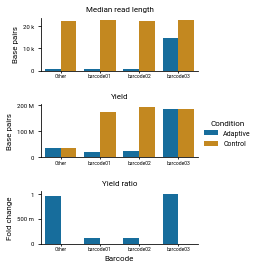

In [18]:
g = (
    sns.catplot(
        data=value_df,
        errorbar=None,
        row="value_type",
        hue="Condition",
        x="Barcode",
        kind="bar",
        y="value",
        height=1.3,
        aspect=2.3,
        sharey="row",
        sharex=False,
    )
    .tick_params(rotation=0, axis="x", pad=1.1, length=1.8)
    .set_titles(template="{row_name}")
)
axes = g.axes.flatten()
y_axis_labels = ("Base pairs", "Base pairs", "Fold change")
for i, ax in enumerate(axes):
    ax.yaxis.set_major_formatter(EngFormatter())
    ax.set_ylabel(y_axis_labels[i])
    ax.set_facecolor("#FFFFFF")

In [19]:
g.fig.savefig(
    "barcode_supplementary.jpg", bbox_inches="tight", dpi=350, transparent=False
)